In [1]:
%load_ext nb_black
%load_ext autoreload

%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import os
from pathlib import Path

from requests import get
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

import logging

logging.basicConfig(level=logging.WARN)

<IPython.core.display.Javascript object>

In [3]:
from xplainet.input_utils import preproc_dataset
from xplainet.model import build_model
from xplainet.random_utils import setup_seed, SEED
from sklearn.model_selection import StratifiedShuffleSplit

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

from zipfile import ZipFile

<IPython.core.display.Javascript object>

In [4]:
setup_seed()

<IPython.core.display.Javascript object>

In [5]:
def download(url, out, force=False, verify=True):
    out.parent.mkdir(parents=True, exist_ok=True)
    if force and out.exists():
        print(f"Removing file at {str(out)}")
        out.unlink()

    if out.exists():
        print("File already exists.")
        return
    print(f"Downloading {url} at {str(out)} ...")
    # open in binary mode
    with out.open(mode="wb") as file:
        # get request
        response = get(url, verify=verify)
        for chunk in response.iter_content(100000):
            # write to file
            file.write(chunk)


<IPython.core.display.Javascript object>

In [6]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if "loss" in s and "val" not in s]
    val_loss_list = [s for s in history.history.keys() if "loss" in s and "val" in s]
    acc_list = [s for s in history.history.keys() if "AUC" in s and "val" not in s]
    val_acc_list = [s for s in history.history.keys() if "AUC" in s and "val" in s]

    if len(loss_list) == 0:
        print("Loss is missing in history")
        return

    ## As loss always exists
    epochs = range(1, len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "b",
            label="Training loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )
    for l in val_loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "g",
            label="Validation loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )

    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

<IPython.core.display.Javascript object>

## Bank marketing : loading data

In [7]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
dataset_name = "wine-quality"
out = Path(os.getcwd() + "/data/" + dataset_name + ".csv")

download(url, out)

target = "quality"
to_remove = []
train = pd.read_csv(out, sep=";", low_memory=False)

<IPython.core.display.Javascript object>

In [8]:
train.shape

(1599, 12)

<IPython.core.display.Javascript object>

In [9]:
train.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

<IPython.core.display.Javascript object>

In [10]:
if "Set" not in train.columns:
    print("Building tailored column")
    train_valid_index, test_index = next(
        StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED).split(
            range(train[target].shape[0]), train[target].values
        )
    )
    train_index, valid_index = next(
        StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED).split(
            train_valid_index, train[target].values[train_valid_index]
        )
    )
    train["Set"] = "train"
    train["Set"][valid_index] = "valid"
    train["Set"][test_index] = "test"
    # train.to_csv((out.parent / "train_bench.csv").as_posix(), index=False)

Building tailored column


/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>

In [11]:
train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices = train[train.Set == "test"].index

<IPython.core.display.Javascript object>

In [12]:
input_train, params = preproc_dataset(train.loc[train_indices], target, ["Set"])
params

{'constant_cols': [],
 'bool_cols': [],
 'num_cols': ['sulphates',
  'fixed acidity',
  'volatile acidity',
  'pH',
  'citric acid',
  'density',
  'residual sugar',
  'total sulfur dioxide',
  'chlorides'],
 'cat_cols': ['free sulfur dioxide', 'alcohol'],
 'num_encoder': [FeatureUnion(transformer_list=[('fillna',
                                  Pipeline(steps=[('fillna',
                                                   SimpleImputer(fill_value=0.35252137039077047,
                                                                 strategy='constant'))]))]),
  FeatureUnion(transformer_list=[('fillna',
                                  Pipeline(steps=[('fillna',
                                                   SimpleImputer(fill_value=4.430469800926217,
                                                                 strategy='constant'))]))]),
  FeatureUnion(transformer_list=[('fillna',
                                  Pipeline(steps=[('fillna',
                                   

<IPython.core.display.Javascript object>

In [13]:
len(train_indices)

1310

<IPython.core.display.Javascript object>

In [14]:
input_valid, _ = preproc_dataset(train.loc[valid_indices], target, ["Set"], params)
input_test, _ = preproc_dataset(train.loc[test_indices], target, ["Set"], params)

<IPython.core.display.Javascript object>

In [15]:
# target_encoder = LabelEncoder()

<IPython.core.display.Javascript object>

In [16]:
# train[target] = target_encoder.fit_transform(train[target].values.reshape(-1))
y_train = train[target].values[train_indices]
y_valid = train[target].values[valid_indices]
y_test = train[target].values[test_indices]

<IPython.core.display.Javascript object>

In [17]:
params

{'constant_cols': [],
 'bool_cols': [],
 'num_cols': ['sulphates',
  'fixed acidity',
  'volatile acidity',
  'pH',
  'citric acid',
  'density',
  'residual sugar',
  'total sulfur dioxide',
  'chlorides'],
 'cat_cols': ['free sulfur dioxide', 'alcohol'],
 'num_encoder': [FeatureUnion(transformer_list=[('fillna',
                                  Pipeline(steps=[('fillna',
                                                   SimpleImputer(fill_value=0.35252137039077047,
                                                                 strategy='constant'))]))]),
  FeatureUnion(transformer_list=[('fillna',
                                  Pipeline(steps=[('fillna',
                                                   SimpleImputer(fill_value=4.430469800926217,
                                                                 strategy='constant'))]))]),
  FeatureUnion(transformer_list=[('fillna',
                                  Pipeline(steps=[('fillna',
                                   

<IPython.core.display.Javascript object>

In [18]:
model = build_model(
    params,
    lconv_dim=[4],
    lconv_num_dim=[8],
    emb_size=16,
    activation_num_first_layer=None,  # "tanh",
    output_activation=None,
    output_dim=1,  # np.unique(y_train).shape[0],
)

/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/tensorflow_addons/options.py:47: RuntimeWarning: Traceback (most recent call last):
  File "/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/tensorflow_addons/activations/mish.py", line 44, in mish
    return _mish_custom_op(x)
  File "/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/tensorflow_addons/activations/mish.py", line 59, in _mish_custom_op
    return _activation_so.ops.addons_mish(x)
  File "/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/tensorflow_addons/utils/resource_loader.py", line 64, in ops
    self._ops = tf.load_op_library(get_path_to_datafile(self.relative_path))
  File "/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/tensorflow/python/framework/load_library.py", line 58, in load_op_library
    lib_handle = py_tf.TF_LoadLibrary(library_filename)
tensorflow.python.framework.errors_impl.NotFoundError: /

<IPython.core.display.Javascript object>

In [19]:
model.summary()

Model: "explainable_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_num (InputLayer)          [(None, 9)]          0                                            
__________________________________________________________________________________________________
input_cat (InputLayer)          [(None, 2)]          0                                            
__________________________________________________________________________________________________
reshape_num_input (Reshape)     (None, 9, 1)         0           input_num[0][0]                  
__________________________________________________________________________________________________
large_emb (Embedding)           (None, 2, 16)        1040        input_cat[0][0]                  
__________________________________________________________________________________

<IPython.core.display.Javascript object>

In [20]:
#!pip install pydot graphviz

<IPython.core.display.Javascript object>

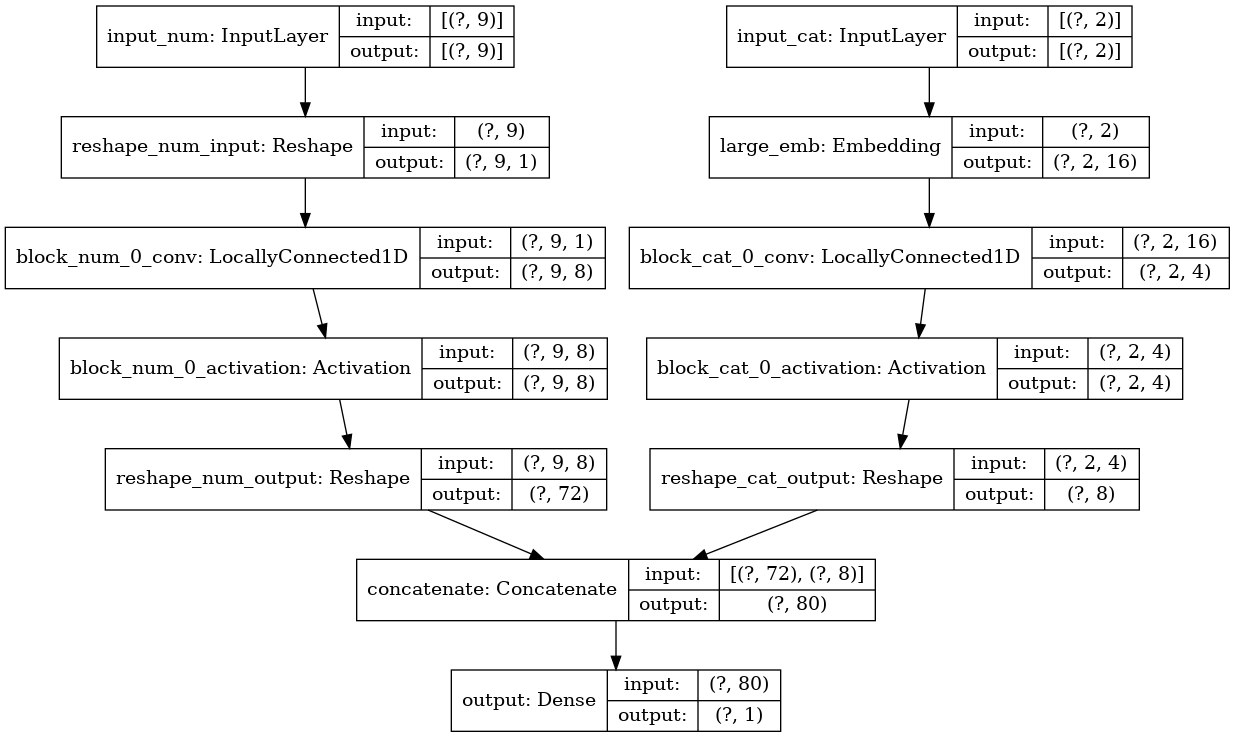

<IPython.core.display.Javascript object>

In [21]:
plot_model(
    model,
    # to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [22]:
y_train.shape

(1310,)

<IPython.core.display.Javascript object>

In [23]:
counts = np.unique(y_train, return_counts=True)[1]
counts = counts.sum() / counts

<IPython.core.display.Javascript object>

In [24]:
class_weight = {}
for i, counts in enumerate(counts):
    class_weight[i] = counts
class_weight

{0: 145.55555555555554,
 1: 28.47826086956522,
 2: 2.347670250896057,
 3: 2.5387596899224807,
 4: 7.844311377245509,
 5: 93.57142857142857}

<IPython.core.display.Javascript object>

In [25]:
%%time
history = model.fit(
    input_train,
    y_train.reshape(-1, 1),
    epochs=2000,
    batch_size=1024,
    validation_data=(input_valid, y_valid.reshape(-1, 1),),
    verbose=2,
    callbacks=[EarlyStopping(monitor="val_loss", patience=50, verbose=1)],
    #class_weight=None#class_weight
)

Epoch 1/2000
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2/2 - 0s - loss: 15.8573 - val_loss: 16.0223
Epoch 2/2000
2/2 - 0s - loss: 14.3166 - val_loss: 12.9056
Epoch 3/2000
2/2 - 0s - loss: 12.2548 - val_loss: 13.1201
Epoch 4/2000
2/2 - 0s - loss: 13.3244 - val_loss: 13.1123
Epoch 5/2000
2/2 - 0s - loss: 13.3157 - val_loss: 13.0996
Epoch 6/2000
2/2 - 0s - loss: 13.3014 - val_loss: 13.1014
Epoch 7/2000
2/2 - 0s - loss: 13.3025 - val_loss: 13.0803
Epoch 8/2000
2/2 - 0s - loss: 13.2792 - val_loss: 13.0557
Epoch 9/2000
2/2 - 0s - loss: 13.2511 - val_loss: 13.0646
Epoch 10/2000
2/2 - 0s - loss: 13.2608 - val_loss: 13.0338
Epoch 11/2000
2/2 - 0s - loss: 13.2264 - val_loss: 13.0007
Epoch 12/2000
2/2 - 0s - loss: 13.1888 - val_loss: 13.0147
Epoch 13/2000
2/2 - 0s - loss: 13.2040 - val_loss: 12.9770
Epoch 14/2000
2/2 - 0s - loss: 13.1615 - val_loss: 12.9376
Epoch 15/2000
2/2 - 0s - loss: 13.1168 - val_loss: 12.9552
Epoch 16/2000
2/2 - 0s - loss: 13.1365 - val_loss: 12.9122
Epoch 17/2000
2/2 - 0s - loss: 13.0874 - val_loss: 12.8680
Epoch 18/2000
2/2 -

Epoch 140/2000
2/2 - 0s - loss: 9.8467 - val_loss: 10.0186
Epoch 141/2000
2/2 - 0s - loss: 9.7926 - val_loss: 10.0461
Epoch 142/2000
2/2 - 0s - loss: 9.8193 - val_loss: 9.9907
Epoch 143/2000
2/2 - 0s - loss: 9.7656 - val_loss: 9.9344
Epoch 144/2000
2/2 - 0s - loss: 9.7108 - val_loss: 9.9626
Epoch 145/2000
2/2 - 0s - loss: 9.7380 - val_loss: 9.9074
Epoch 146/2000
2/2 - 0s - loss: 9.6829 - val_loss: 9.8513
Epoch 147/2000
2/2 - 0s - loss: 9.6279 - val_loss: 9.8785
Epoch 148/2000
2/2 - 0s - loss: 9.6554 - val_loss: 9.8211
Epoch 149/2000
2/2 - 0s - loss: 9.5996 - val_loss: 9.7643
Epoch 150/2000
2/2 - 0s - loss: 9.5432 - val_loss: 9.7932
Epoch 151/2000
2/2 - 0s - loss: 9.5713 - val_loss: 9.7368
Epoch 152/2000
2/2 - 0s - loss: 9.5148 - val_loss: 9.6810
Epoch 153/2000
2/2 - 0s - loss: 9.4576 - val_loss: 9.7096
Epoch 154/2000
2/2 - 0s - loss: 9.4855 - val_loss: 9.6544
Epoch 155/2000
2/2 - 0s - loss: 9.4290 - val_loss: 9.5975
Epoch 156/2000
2/2 - 0s - loss: 9.3704 - val_loss: 9.6240
Epoch 157/20

2/2 - 0s - loss: 4.8156 - val_loss: 4.9584
Epoch 282/2000
2/2 - 0s - loss: 4.7366 - val_loss: 4.9973
Epoch 283/2000
2/2 - 0s - loss: 4.7761 - val_loss: 4.9190
Epoch 284/2000
2/2 - 0s - loss: 4.6960 - val_loss: 4.8402
Epoch 285/2000
2/2 - 0s - loss: 4.6180 - val_loss: 4.8778
Epoch 286/2000
2/2 - 0s - loss: 4.6560 - val_loss: 4.7948
Epoch 287/2000
2/2 - 0s - loss: 4.5778 - val_loss: 4.7114
Epoch 288/2000
2/2 - 0s - loss: 4.4972 - val_loss: 4.7528
Epoch 289/2000
2/2 - 0s - loss: 4.5377 - val_loss: 4.6701
Epoch 290/2000
2/2 - 0s - loss: 4.4589 - val_loss: 4.5889
Epoch 291/2000
2/2 - 0s - loss: 4.3802 - val_loss: 4.6308
Epoch 292/2000
2/2 - 0s - loss: 4.4191 - val_loss: 4.5519
Epoch 293/2000
2/2 - 0s - loss: 4.3415 - val_loss: 4.4737
Epoch 294/2000
2/2 - 0s - loss: 4.2628 - val_loss: 4.5134
Epoch 295/2000
2/2 - 0s - loss: 4.3024 - val_loss: 4.4350
Epoch 296/2000
2/2 - 0s - loss: 4.2244 - val_loss: 4.3565
Epoch 297/2000
2/2 - 0s - loss: 4.1460 - val_loss: 4.3953
Epoch 298/2000
2/2 - 0s - los

Epoch 423/2000
2/2 - 0s - loss: 1.0775 - val_loss: 1.2220
Epoch 424/2000
2/2 - 0s - loss: 1.0876 - val_loss: 1.2012
Epoch 425/2000
2/2 - 0s - loss: 1.0682 - val_loss: 1.1813
Epoch 426/2000
2/2 - 0s - loss: 1.0492 - val_loss: 1.1919
Epoch 427/2000
2/2 - 0s - loss: 1.0587 - val_loss: 1.1736
Epoch 428/2000
2/2 - 0s - loss: 1.0405 - val_loss: 1.1557
Epoch 429/2000
2/2 - 0s - loss: 1.0229 - val_loss: 1.1646
Epoch 430/2000
2/2 - 0s - loss: 1.0318 - val_loss: 1.1464
Epoch 431/2000
2/2 - 0s - loss: 1.0145 - val_loss: 1.1274
Epoch 432/2000
2/2 - 0s - loss: 0.9976 - val_loss: 1.1363
Epoch 433/2000
2/2 - 0s - loss: 1.0062 - val_loss: 1.1182
Epoch 434/2000
2/2 - 0s - loss: 0.9896 - val_loss: 1.1010
Epoch 435/2000
2/2 - 0s - loss: 0.9738 - val_loss: 1.1100
Epoch 436/2000
2/2 - 0s - loss: 0.9817 - val_loss: 1.0936
Epoch 437/2000
2/2 - 0s - loss: 0.9664 - val_loss: 1.0776
Epoch 438/2000
2/2 - 0s - loss: 0.9515 - val_loss: 1.0856
Epoch 439/2000
2/2 - 0s - loss: 0.9590 - val_loss: 1.0703
Epoch 440/2000

2/2 - 0s - loss: 0.5996 - val_loss: 0.6898
Epoch 565/2000
2/2 - 0s - loss: 0.6004 - val_loss: 0.6885
Epoch 566/2000
2/2 - 0s - loss: 0.5987 - val_loss: 0.6870
Epoch 567/2000
2/2 - 0s - loss: 0.5969 - val_loss: 0.6877
Epoch 568/2000
2/2 - 0s - loss: 0.5977 - val_loss: 0.6861
Epoch 569/2000
2/2 - 0s - loss: 0.5960 - val_loss: 0.6845
Epoch 570/2000
2/2 - 0s - loss: 0.5942 - val_loss: 0.6853
Epoch 571/2000
2/2 - 0s - loss: 0.5950 - val_loss: 0.6836
Epoch 572/2000
2/2 - 0s - loss: 0.5933 - val_loss: 0.6821
Epoch 573/2000
2/2 - 0s - loss: 0.5915 - val_loss: 0.6831
Epoch 574/2000
2/2 - 0s - loss: 0.5923 - val_loss: 0.6821
Epoch 575/2000
2/2 - 0s - loss: 0.5907 - val_loss: 0.6811
Epoch 576/2000
2/2 - 0s - loss: 0.5890 - val_loss: 0.6814
Epoch 577/2000
2/2 - 0s - loss: 0.5898 - val_loss: 0.6796
Epoch 578/2000
2/2 - 0s - loss: 0.5881 - val_loss: 0.6775
Epoch 579/2000
2/2 - 0s - loss: 0.5864 - val_loss: 0.6785
Epoch 580/2000
2/2 - 0s - loss: 0.5873 - val_loss: 0.6767
Epoch 581/2000
2/2 - 0s - los

Epoch 706/2000
2/2 - 0s - loss: 0.5226 - val_loss: 0.6222
Epoch 707/2000
2/2 - 0s - loss: 0.5220 - val_loss: 0.6217
Epoch 708/2000
2/2 - 0s - loss: 0.5214 - val_loss: 0.6221
Epoch 709/2000
2/2 - 0s - loss: 0.5217 - val_loss: 0.6217
Epoch 710/2000
2/2 - 0s - loss: 0.5211 - val_loss: 0.6212
Epoch 711/2000
2/2 - 0s - loss: 0.5205 - val_loss: 0.6213
Epoch 712/2000
2/2 - 0s - loss: 0.5208 - val_loss: 0.6208
Epoch 713/2000
2/2 - 0s - loss: 0.5202 - val_loss: 0.6206
Epoch 714/2000
2/2 - 0s - loss: 0.5196 - val_loss: 0.6208
Epoch 715/2000
2/2 - 0s - loss: 0.5199 - val_loss: 0.6203
Epoch 716/2000
2/2 - 0s - loss: 0.5192 - val_loss: 0.6198
Epoch 717/2000
2/2 - 0s - loss: 0.5187 - val_loss: 0.6201
Epoch 718/2000
2/2 - 0s - loss: 0.5189 - val_loss: 0.6199
Epoch 719/2000
2/2 - 0s - loss: 0.5183 - val_loss: 0.6196
Epoch 720/2000
2/2 - 0s - loss: 0.5177 - val_loss: 0.6196
Epoch 721/2000
2/2 - 0s - loss: 0.5179 - val_loss: 0.6190
Epoch 722/2000
2/2 - 0s - loss: 0.5174 - val_loss: 0.6181
Epoch 723/2000

2/2 - 0s - loss: 0.4878 - val_loss: 0.5938
Epoch 848/2000
2/2 - 0s - loss: 0.4874 - val_loss: 0.5937
Epoch 849/2000
2/2 - 0s - loss: 0.4871 - val_loss: 0.5938
Epoch 850/2000
2/2 - 0s - loss: 0.4873 - val_loss: 0.5934
Epoch 851/2000
2/2 - 0s - loss: 0.4869 - val_loss: 0.5926
Epoch 852/2000
2/2 - 0s - loss: 0.4865 - val_loss: 0.5928
Epoch 853/2000
2/2 - 0s - loss: 0.4867 - val_loss: 0.5921
Epoch 854/2000
2/2 - 0s - loss: 0.4864 - val_loss: 0.5912
Epoch 855/2000
2/2 - 0s - loss: 0.4860 - val_loss: 0.5915
Epoch 856/2000
2/2 - 0s - loss: 0.4862 - val_loss: 0.5906
Epoch 857/2000
2/2 - 0s - loss: 0.4858 - val_loss: 0.5900
Epoch 858/2000
2/2 - 0s - loss: 0.4855 - val_loss: 0.5905
Epoch 859/2000
2/2 - 0s - loss: 0.4856 - val_loss: 0.5900
Epoch 860/2000
2/2 - 0s - loss: 0.4853 - val_loss: 0.5895
Epoch 861/2000
2/2 - 0s - loss: 0.4850 - val_loss: 0.5899
Epoch 862/2000
2/2 - 0s - loss: 0.4851 - val_loss: 0.5901
Epoch 863/2000
2/2 - 0s - loss: 0.4848 - val_loss: 0.5901
Epoch 864/2000
2/2 - 0s - los

<IPython.core.display.Javascript object>

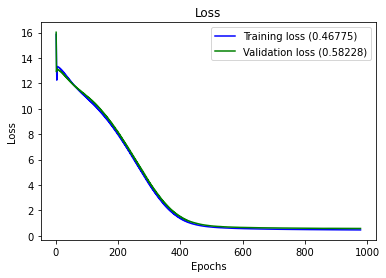

<IPython.core.display.Javascript object>

In [26]:
plot_history(history)

In [27]:
model_auc = mean_absolute_error(
    y_pred=model.predict(input_valid).reshape(-1), y_true=y_valid
)
model_auc

0.5725643653278203

<IPython.core.display.Javascript object>

In [28]:
model_auc = mean_squared_error(
    y_pred=model.predict(input_valid).reshape(-1), y_true=y_valid
)
model_auc

0.5822807001926152

<IPython.core.display.Javascript object>

In [29]:
model_auc = mean_absolute_error(
    y_pred=model.predict(input_test).reshape(-1), y_true=y_test
)
model_auc

0.5515555024147034

<IPython.core.display.Javascript object>

In [30]:
model_auc = mean_squared_error(
    y_pred=model.predict(input_test).reshape(-1), y_true=y_test
)
model_auc

0.5177609326043268

<IPython.core.display.Javascript object>

In [31]:
from xplainet.model import predict, encode

<IPython.core.display.Javascript object>

In [32]:
probs, explanations = predict(model, input_test)

<IPython.core.display.Javascript object>

In [33]:
probs, encoded_output = encode(model, input_test)

<IPython.core.display.Javascript object>

In [34]:
y_test.shape

(160,)

<IPython.core.display.Javascript object>

In [35]:
encoded_output.shape

(160, 80)

<IPython.core.display.Javascript object>

In [36]:
explanations.shape

(160, 11)

<IPython.core.display.Javascript object>

In [37]:
import matplotlib.pyplot as plt

# plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt


def explain_plot(importances, columns):
    selection = np.argsort(-np.absolute(importances))[:10]
    # indexes = np.argsort(importances)
    performance = importances[selection]
    #     print(performance.shape)512, 256, 128, 64, 32, 1
    y_pos = np.arange(performance.shape[0])

    plt.barh(y_pos, performance, align="center", alpha=0.5)
    plt.yticks(y_pos, columns[selection])
    # plt.xlabel('Usage')
    plt.title("Feature importance")

    plt.show()

<IPython.core.display.Javascript object>

In [38]:
all_cols = np.array(params["bool_cols"] + params["num_cols"] + params["cat_cols"])
all_cols

array(['sulphates', 'fixed acidity', 'volatile acidity', 'pH',
       'citric acid', 'density', 'residual sugar', 'total sulfur dioxide',
       'chlorides', 'free sulfur dioxide', 'alcohol'], dtype='<U20')

<IPython.core.display.Javascript object>

## Explain global

In [39]:
# Looks like this is broken for now.

<IPython.core.display.Javascript object>

In [40]:
probs_train, explanations_train = predict(model, input_train)

<IPython.core.display.Javascript object>

In [41]:
global_explain = np.abs(explanations_train).sum(axis=0)
global_explain = global_explain / np.abs(global_explain).sum()

<IPython.core.display.Javascript object>

In [42]:
global_explain

array([0.09086092, 0.09091417, 0.0908455 , 0.09107754, 0.09084366,
       0.09086285, 0.090867  , 0.09085719, 0.09084128, 0.09091581,
       0.09111409])

<IPython.core.display.Javascript object>

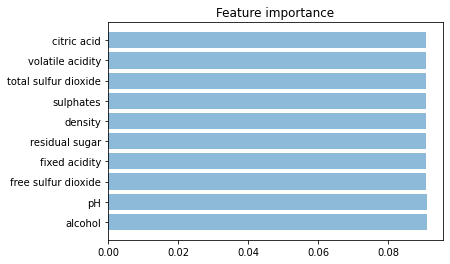

<IPython.core.display.Javascript object>

In [43]:
explain_plot(global_explain, all_cols)

## Explain local

In [44]:
# Looks like this is broken for now.

<IPython.core.display.Javascript object>

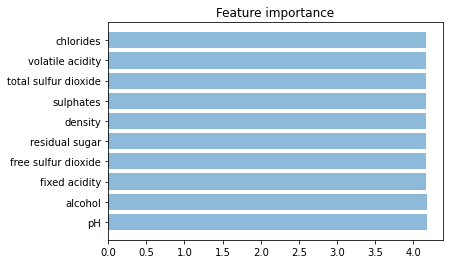

5.155357837677002


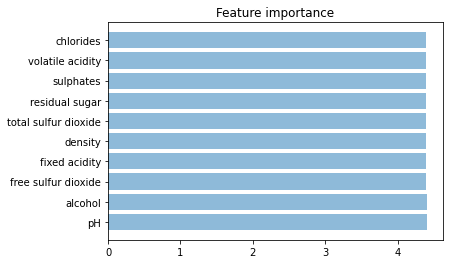

5.385986328125


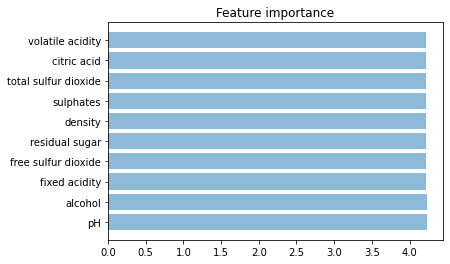

5.207136154174805


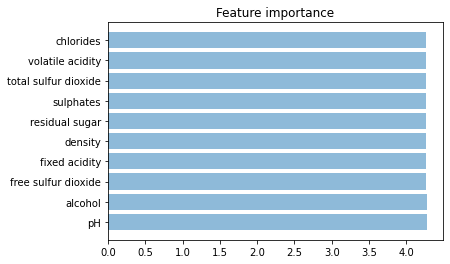

5.255589962005615


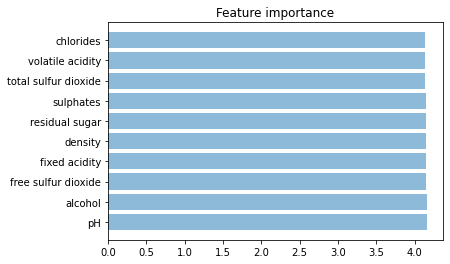

5.1348490715026855


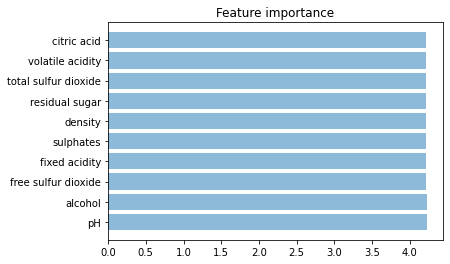

5.206116199493408


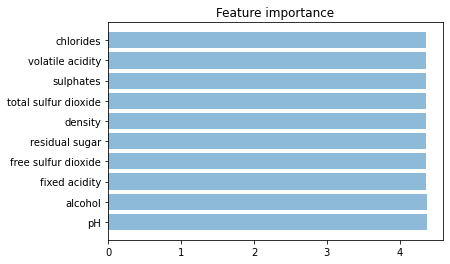

5.352466106414795


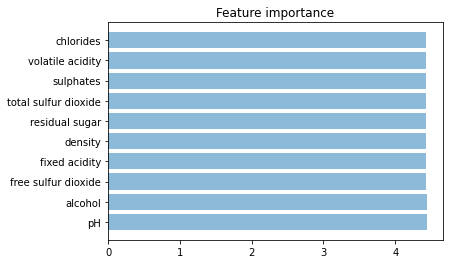

5.423414707183838


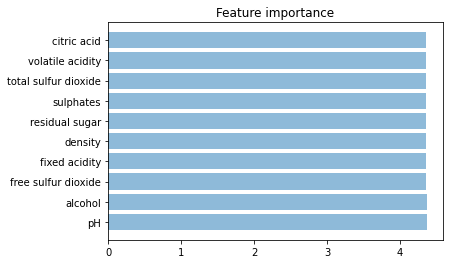

5.348320484161377


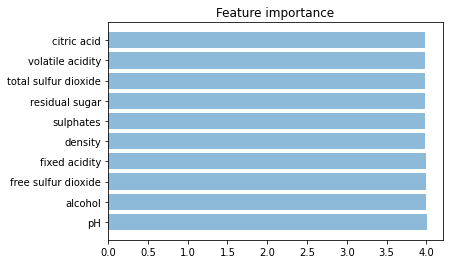

4.979255199432373


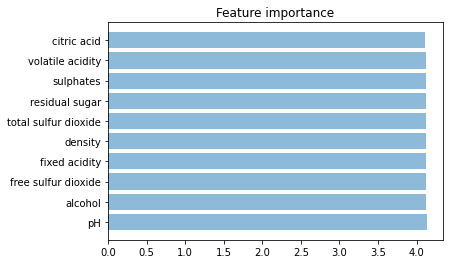

5.109804630279541


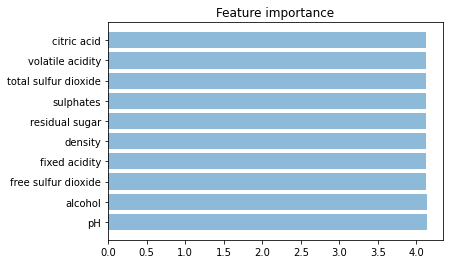

5.1121649742126465


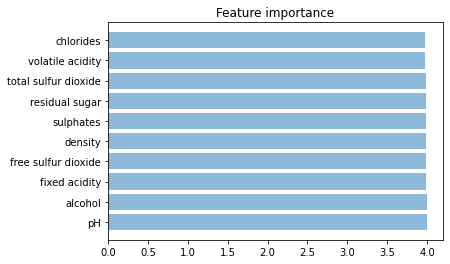

4.972585201263428


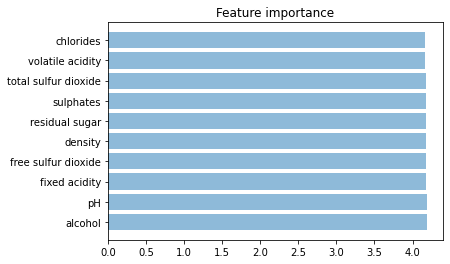

5.163723468780518


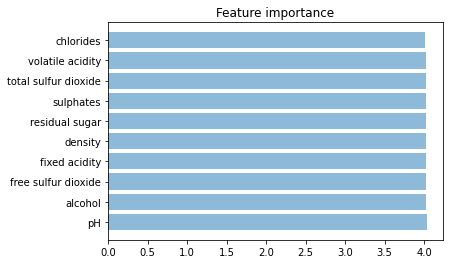

5.011050701141357


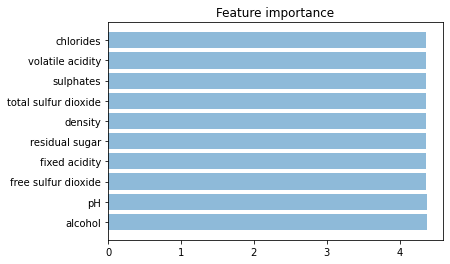

5.351734638214111


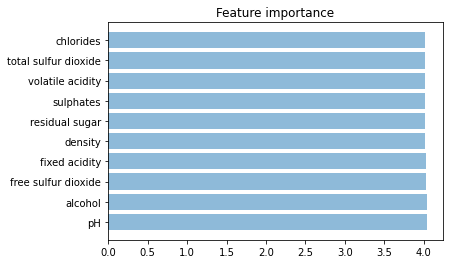

5.011688709259033


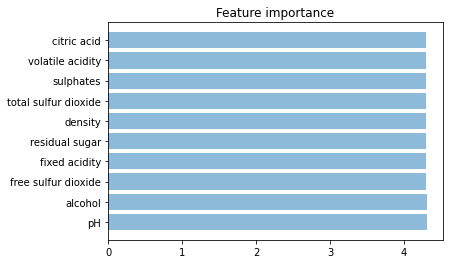

5.288669109344482


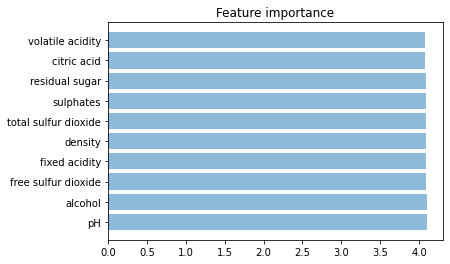

5.075244426727295


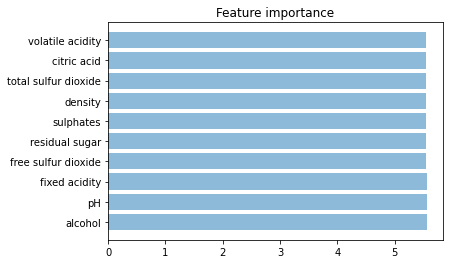

6.550312519073486


<IPython.core.display.Javascript object>

In [45]:
for i in range(20):
    explain_plot(explanations[i], all_cols)
    print(probs[i].item())

In [46]:
from sklearn.metrics import confusion_matrix

<IPython.core.display.Javascript object>

In [47]:
probs_test, explanations_train = predict(model, input_test)

<IPython.core.display.Javascript object>

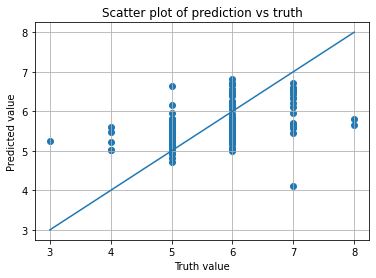

<IPython.core.display.Javascript object>

In [48]:
# plt.barh(y_pos, performance, align="center", alpha=0.5)
# plt.yticks(y_pos, columns[selection])
plt.ylabel("Predicted value")
plt.xlabel("Truth value")

plt.title("Scatter plot of prediction vs truth")
plt.scatter(y_test, probs_test)
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)])
plt.grid(True)
plt.show()

In [49]:
probs_test

array([[5.155358 ],
       [5.3859863],
       [5.207136 ],
       [5.25559  ],
       [5.134849 ],
       [5.206116 ],
       [5.352466 ],
       [5.4234147],
       [5.3483205],
       [4.979255 ],
       [5.1098046],
       [5.112165 ],
       [4.972585 ],
       [5.1637235],
       [5.0110507],
       [5.3517346],
       [5.0116887],
       [5.288669 ],
       [5.0752444],
       [6.5503125],
       [4.817222 ],
       [5.615053 ],
       [5.7280564],
       [5.8001885],
       [5.690249 ],
       [5.3275294],
       [5.8655553],
       [5.5934253],
       [5.5136843],
       [5.251225 ],
       [5.697165 ],
       [5.272288 ],
       [5.6685634],
       [5.552794 ],
       [5.3117156],
       [5.445111 ],
       [6.1224236],
       [6.819473 ],
       [6.48958  ],
       [6.5828805],
       [5.591359 ],
       [5.336201 ],
       [5.1947775],
       [6.3428226],
       [5.607508 ],
       [6.038602 ],
       [5.018456 ],
       [5.7368937],
       [4.9231553],
       [5.3415723],


<IPython.core.display.Javascript object>

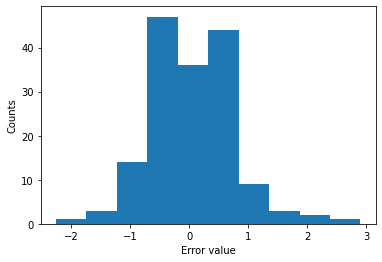

<IPython.core.display.Javascript object>

In [50]:
plt.hist(y_test.reshape(-1) - probs_test.reshape(-1), bins=10)
plt.xlabel("Error value")
plt.ylabel("Counts")
plt.show()

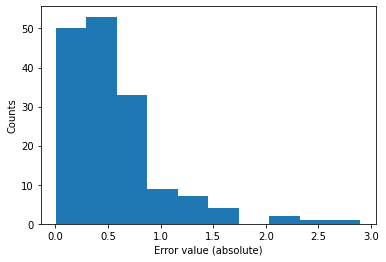

<IPython.core.display.Javascript object>

In [51]:
plt.hist(np.abs(y_test.reshape(-1) - probs_test.reshape(-1)), bins=10)
plt.xlabel("Error value (absolute)")
plt.ylabel("Counts")
plt.show()